The main package for these demos:

In [1]:
using QuantumClifford

For visualizing the states under study, we have Makie recipes:

In [2]:
using CairoMakie

We will also use QuantumOpticsBase to convert to state vector repr
for visualization in a more familiar formalism:

In [3]:
using QuantumOpticsBase

and BenchmarkTools to measure performance:

In [4]:
using BenchmarkTools

# Pauli operators

to define an operator, we can use the `P"..."` syntax

In [5]:
P"Z"

+ Z

to convert to state vector repr, we can use the `Operator` constructor

In [6]:
P"Z" |> Operator # from QuantumOptics

Operator(dim=2x2)
  basis: Spin(1/2)
 1.0 + 0.0im        ⋅     
      ⋅       -1.0 + 0.0im

same for Pauli X, and tensor products

In [7]:
P"X" |> Operator

Operator(dim=2x2)
  basis: Spin(1/2)
      ⋅       1.0 + 0.0im
 1.0 + 0.0im       ⋅     

shorthand syntax for tensor products

In [8]:
P"XX" == P"X" ⊗ P"X"

true

low level function to check for commutativity

In [9]:
comm(P"X", P"Z")

0x01

One of the value adds of this package is that behind
the convenient syntax, the low-level representation
of the operators is very compact and fast.

In [10]:
a_billion = 1_000_000_000
l = random_pauli(a_billion)
r = random_pauli(a_billion)

@benchmark comm(l, r)

BenchmarkTools.Trial: 609 samples with 1 evaluation per sample.
 Range (min … max):  7.972 ms …  10.082 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.184 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.202 ms ± 185.312 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄  ▁   ▁▆▂▂▁▂▃█▂▂▂▁ ▂                                       
  ██████▇▆████████████▇█▇▇▆▆▅▅▄▃▄▅▃▂▄▃▃▁▁▂▂▁▁▃▃▁▂▂▁▂▂▁▁▁▁▁▁▂▂ ▄
  7.97 ms         Histogram: frequency by time        8.83 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

Two bits per Pauli; multiple qubits packed in a single Int primitive type.

In [11]:
p = P"XIZY"

bitstring.(UInt8.(p.xz))

bits(arr) = bitstring.(UInt8.(arr));

## Pauli multiplication is bitwise ⊻ (XOR)

In [12]:
P"X" * P"Z"

-iY

In [13]:
(P"XYI".xz, P"ZZI".xz) .|> bits

(["00000011", "00000010"], ["00000000", "00000011"])

In [14]:
(P"XYI" * P"ZZI").xz .|> bits

2-element Vector{String}:
 "00000011"
 "00000001"

In [15]:
(P"XYI".xz .⊻ P"ZZI".xz) .|> bits

2-element Vector{String}:
 "00000011"
 "00000001"

# Stabilizer states

Instead of defining a state by its amplitudes in a given basis,
we can define it by specifying a commuting set of operators for which
the state is an eigenstate with known eigenvalues.
That is known as the Heienberg picture.
We call these operators "stabilizing operators".

In [16]:
S"X"

+ X

In [17]:
S"X" |> Ket

Ket(dim=2)
  basis: Spin(1/2)
 0.7071067811865475 + 0.0im
 0.7071067811865475 + 0.0im

In [18]:
S"Z" |> Ket

Ket(dim=2)
  basis: Spin(1/2)
 0.9999999999999999 + 0.0im
                0.0 + 0.0im

In [19]:
S"Z" ⊗ S"Z"

+ Z_
+ _Z

In [20]:
S"ZI IZ" |> Ket

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.9999999999999997 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [21]:
S"ZI -IZ" |> Ket

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
                0.0 + 0.0im
                0.0 + 0.0im
 0.9999999999999997 + 0.0im
                0.0 + 0.0im

In [22]:
S"XX ZZ" |> Ket

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.7071067811865474 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
 0.7071067811865474 + 0.0im

It is helpful to think of them as a system of linear equations,
a set of constraints that have only one solution,
the unique state being stabilized.

There are many ways to write equivalent set of equations,
e.g. just by doing row operations on the matrix of coefficients.

In [23]:
state = S"ZI IZ"

+ Z_
+ _Z

In [24]:
row1 = state[1]
row2 = state[2]
new_state = Stabilizer([row1, row1*row2])

+ Z_
+ ZZ

In [25]:
state |> Ket

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.9999999999999997 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

In [26]:
new_state |> Ket

Ket(dim=4)
  basis: [Spin(1/2) ⊗ Spin(1/2)]
 0.9999999999999997 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im
                0.0 + 0.0im

You can do (binary) Gaussian elimination to get a canonical form.

In [27]:
canonicalize!(new_state)

+ Z_
+ _Z

There is a variety of different ways to do the Gaussian elimination
(do you run first X, then Z, interleave, etc), and each is useful in different contexts.

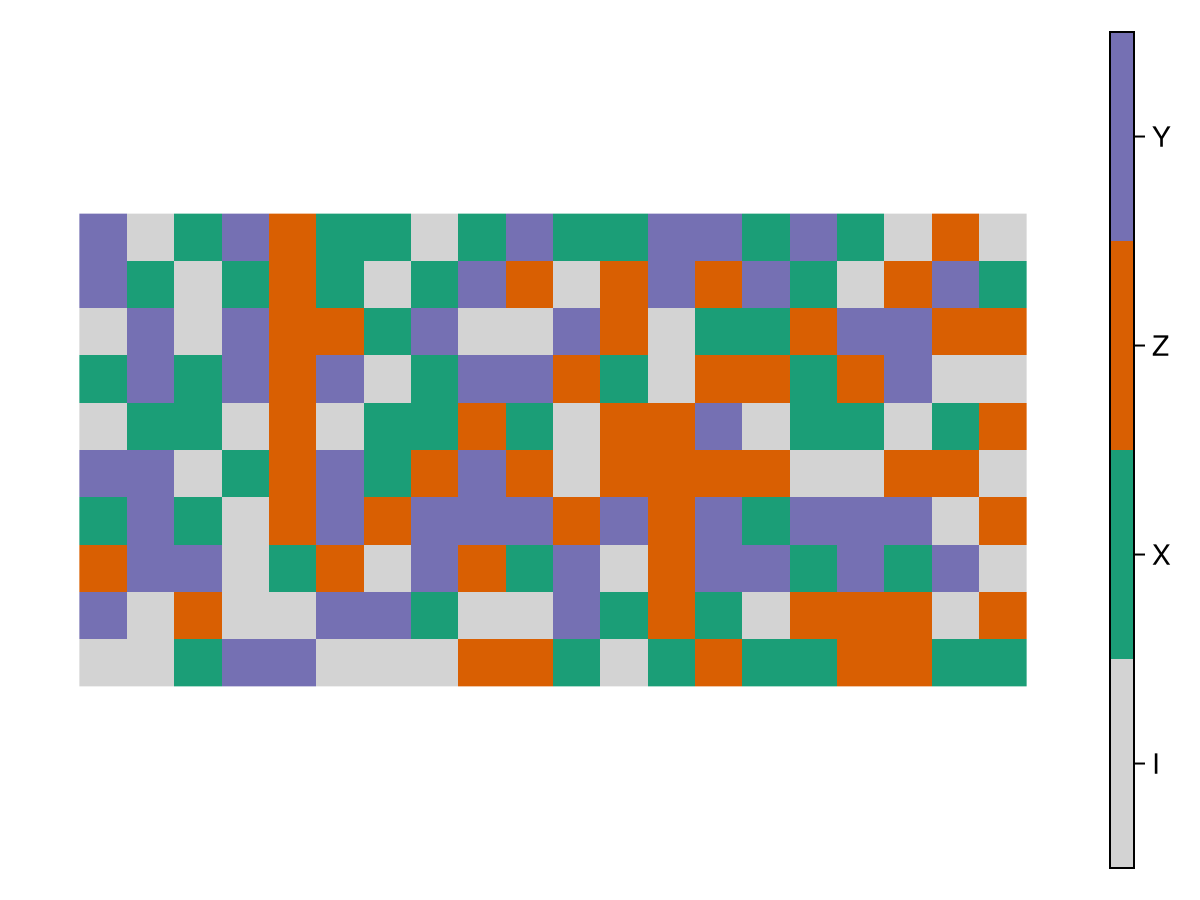

In [28]:
state = random_stabilizer(10, 20);
fig = Figure();
stabilizerplot_axis(fig[1,1], state);
fig

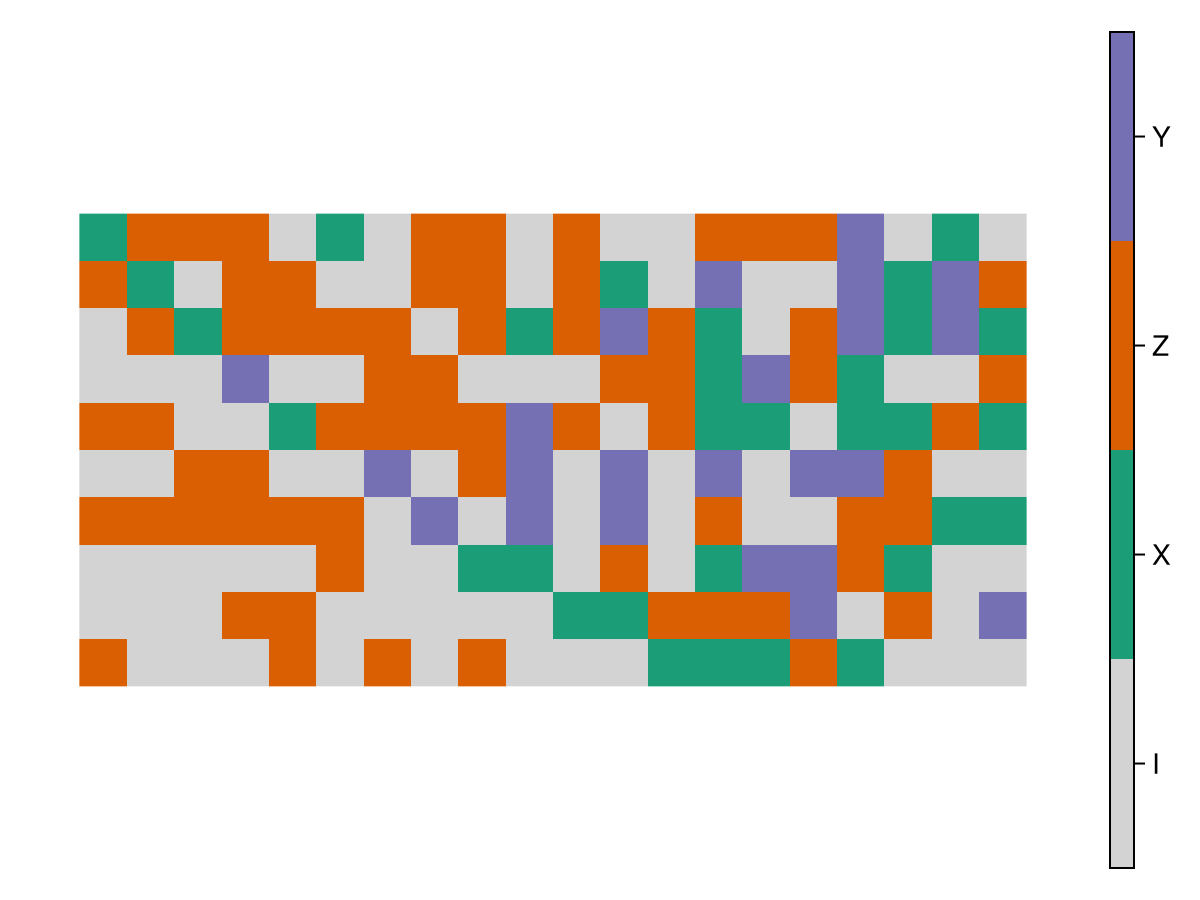

In [29]:
canonicalize!(state);
fig = Figure();
stabilizerplot_axis(fig[1,1], state);
fig

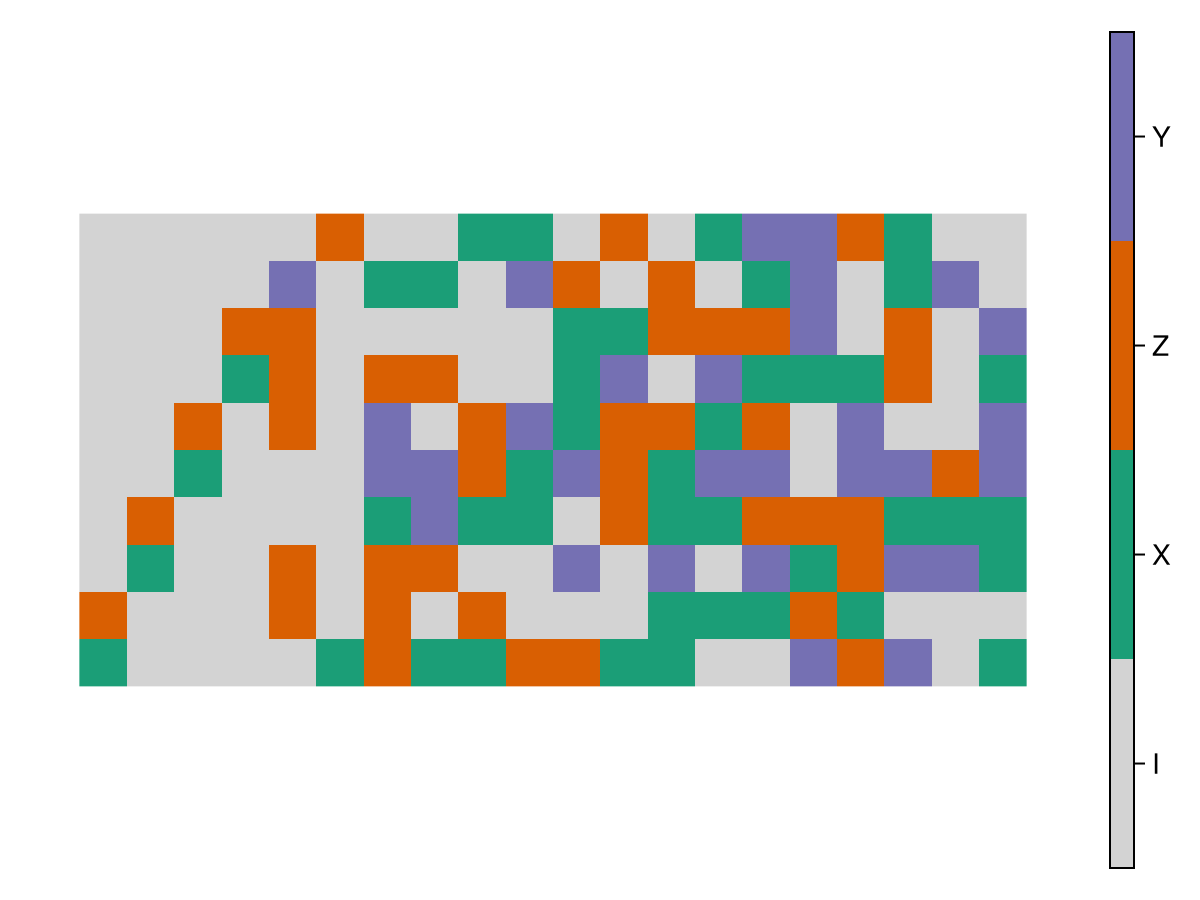

In [30]:
canonicalize_rref!(state);
fig = Figure();
stabilizerplot_axis(fig[1,1], state);
fig

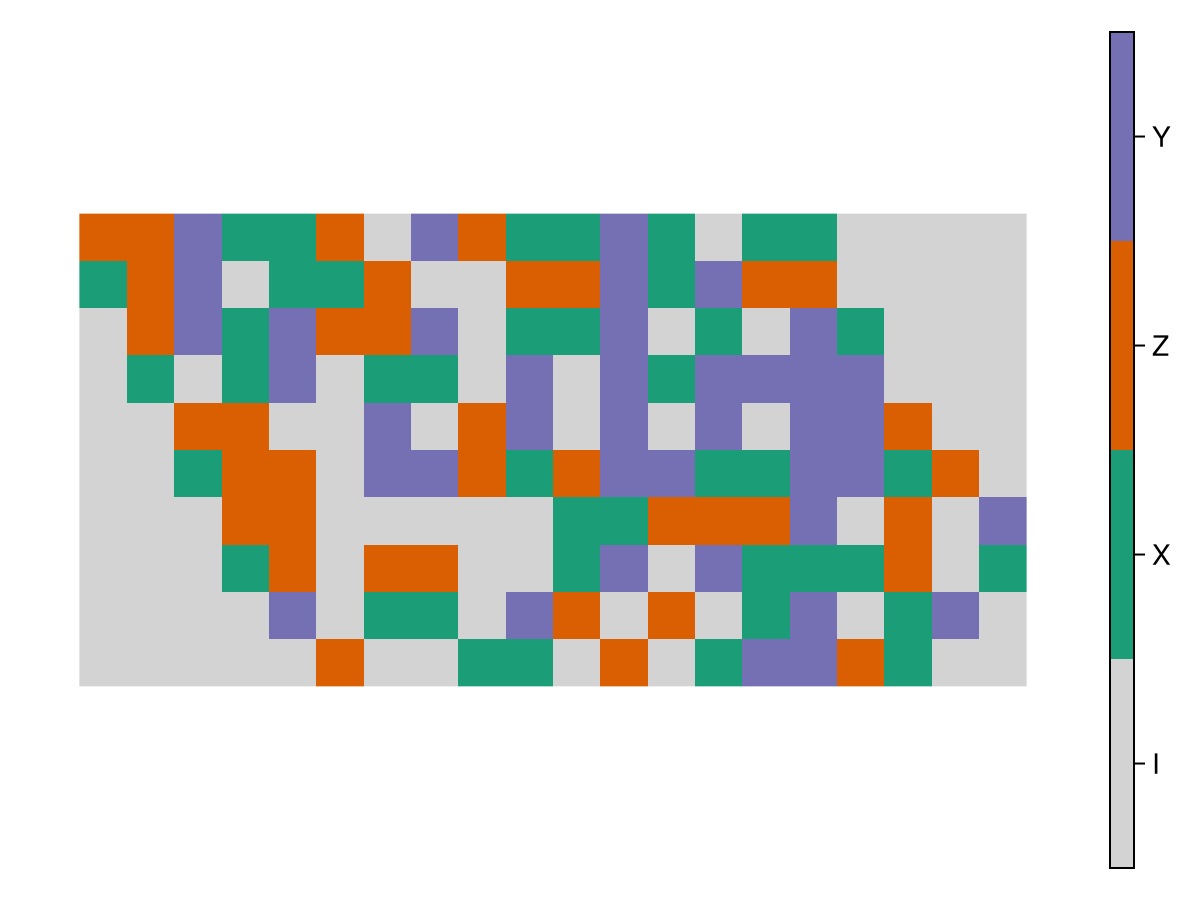

In [31]:
canonicalize_clip!(state);
fig = Figure();
stabilizerplot_axis(fig[1,1], state);
fig

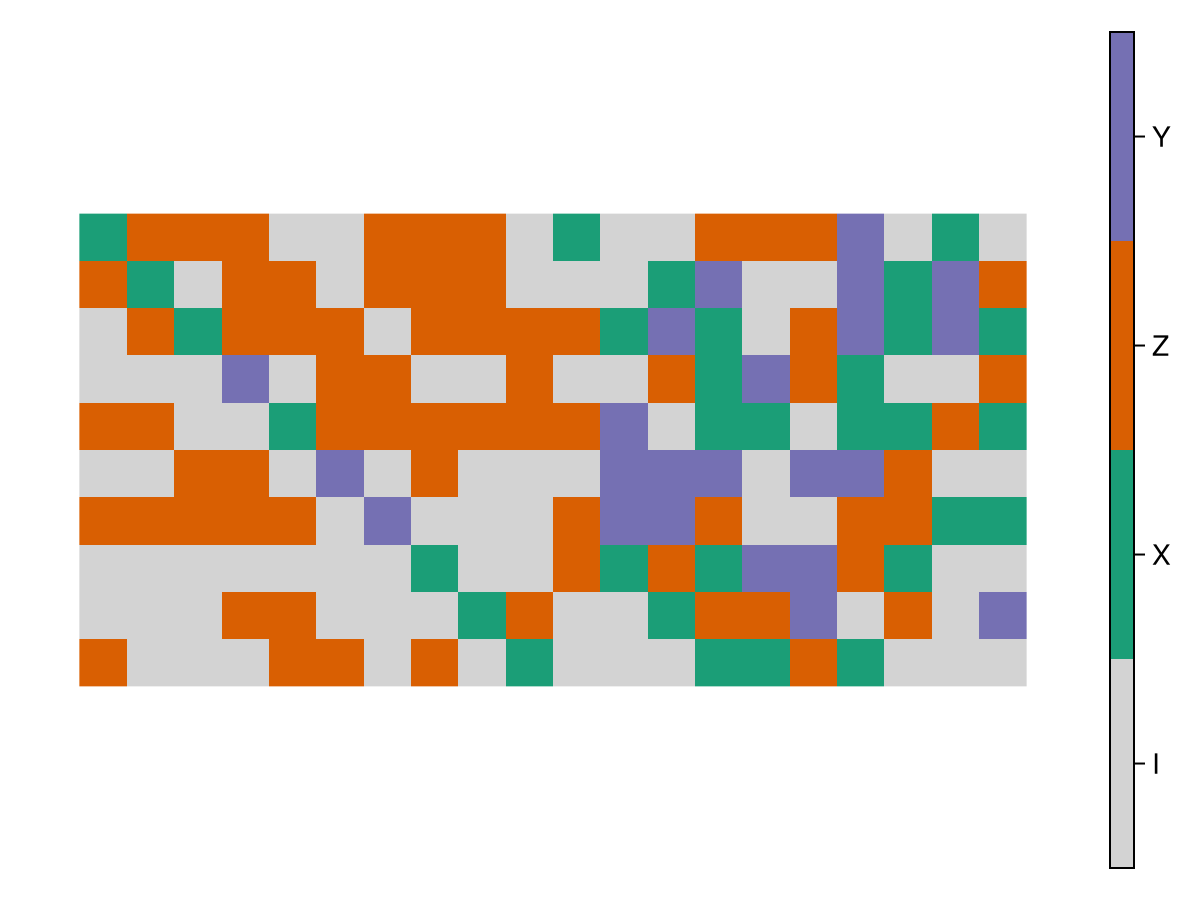

In [32]:
canonicalize_gott!(state);
fig = Figure();
stabilizerplot_axis(fig[1,1], state);
fig

# Unitary dynamics of a Stabilizer state

If we have a Unitary `U` and a state `|ψ⟩`, then `U|ψ⟩` is the new state after evolution.

If we use the Heisenberg picture, we have an Operator `O` used as a stand-in to represent
its eigenstate `|ψ⟩`. Then the stand-in for the evolved state is `U O U†`.

On its this is not a more efficient representation.
It is computationally worse -- we need to track a bunch of matrix-matrix multiplications,
instead of a single matrix-vector multiplication.
However things change, if we:
    - stick only to operators that are efficient to implicitly represent
    - and have an efficient rule how to update the operator when we apply a gate

then we can avoid the exponential cost of the typical state vector representation.

If the operators we use in the Heisenberg picture are only Pauli operators,
then we do have everything we need for efficient representation,
but what we lose is that we now support only Unitaries from the Clifford group,
i.e. the unitary subgroup that maps Pauli operators to Pauli operators.

## Clifford action as binary matrix multiplication

We can write Pauli operators as binary vectors,
and we can decompose such vectors into weighted sums of basis vectors.

In [33]:
P"XYZ"

+ XYZ

In [34]:
P"XII" * P"IXI" * P"IZI" * P"IIZ"

-iXYZ

Above we have the "sum" of four Pauli "binary basis vectors".

The confusing thing is that these three are the same:
    - multiplication of Pauli matrices
    - addition (mod 2) of the binary representation of the Pauli matrices
    - bitwise XOR of the binary representation of the Pauli matrices

The application of Clifford unitaries is now simply a binary matrix multiplication.

In [35]:
tCNOT

X₁ ⟼ + XX
X₂ ⟼ + _X
Z₁ ⟼ + Z_
Z₂ ⟼ + ZZ

Preparing a Bell pair

In [36]:
tCNOT * S"XI IZ"

+ XX
+ ZZ

Starting with a complicated state

In [37]:
tCNOT * S"XY"

+ YZ

In [38]:
P"XI" * P"IX" * P"IZ"

-iXY

In [39]:
tCNOT

X₁ ⟼ + XX
X₂ ⟼ + _X
Z₁ ⟼ + Z_
Z₂ ⟼ + ZZ

In [40]:
P"XX" * P"IX" * P"ZZ"

-iYZ

Let's see it again, but in binary

In [41]:
gf2CNOT = stab_to_gf2(tab(tCNOT))'

4×4 adjoint(::Matrix{Bool}) with eltype Bool:
 1  0  0  0
 1  1  0  0
 0  0  1  1
 0  0  0  1

In [42]:
gf2stab = stab_to_gf2(S"XY")'

4×1 adjoint(::Matrix{Bool}) with eltype Bool:
 1
 1
 0
 1

In [43]:
gf2CNOT * gf2stab .% 2

4×1 Matrix{Int64}:
 1
 0
 1
 1

In [44]:
stab_to_gf2(tCNOT*S"XY")

1×4 Matrix{Bool}:
 1  0  1  1

# Named Small Gates

Usually you just run a circuit involving a single- and two-qubit gates.
For those we have specialized fast gate implementations.

In [45]:
state = random_stabilizer(100);
@benchmark apply!(state, tCNOT, [1,2])

BenchmarkTools.Trial: 10000 samples with 9 evaluations per sample.
 Range (min … max):  2.635 μs …   7.255 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.750 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.797 μs ± 223.126 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁▄▇███▇▆▅▄▄▃▂▁▁            ▁                               ▂
  ▆████████████████▇▇▆▇▆▇▇█▇███████▆▇▇▆▆▇▅▆▅▆▅▇▆▅▆▆▁▄▆▅▄▅▆▅▆▅ █
  2.64 μs      Histogram: log(frequency) by time      3.76 μs <

 Memory estimate: 112 bytes, allocs estimate: 3.

In [46]:
@benchmark apply!(state, sCNOT(1,2))

BenchmarkTools.Trial: 10000 samples with 280 evaluations per sample.
 Range (min … max):  285.757 ns … 524.782 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     290.336 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   292.737 ns ±   8.648 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▄▆█▆▃                                                    
  ▁▁▂▃▅██████▇▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  286 ns           Histogram: frequency by time          316 ns <

 Memory estimate: 32 bytes, allocs estimate: 1.

# Pauli Measurements

Besides unitary dynamics, we also care about measurements.

## Measuring a non-commuting operator

The easy case is when we measure an operator that does not commute with all the stabilizers that define the state.
Just remove the non-commuting stabilizer and put in the measurement operator (with a random phase).

In [47]:
project!(S"X", P"Z")[1] # project! gives a bunch of information; here just get the final state

+ Z

But what if there are more than one non-commuting stabilizers?
Do row operations until only one is left.

Doing it manually to see the steps:

In [48]:
state = S"XXX ZZI IZZ"
meas = P"IXI"

QuantumClifford.mul_left!(state, 3, 2)

+ XXX
+ ZZ_
+ Z_Z

In [49]:
state[2] = meas
state

+ XXX
+ _X_
+ Z_Z

Using the built-in implementation:

In [50]:
project!(S"XXX ZZI IZZ", P"IXI")[1]

+ XXX
+ _X_
+ Z_Z

## Measuring a commuting operator

Now there is a definite answer, and you need to use Gaussian elimination to figure out
what product of existing stabilizers is equal to the measurement operator (up to a phase),
and the phase "difference" would be the measurement result

In [51]:
state = S"XXX ZZI IZZ"
meas = P"YYX"

QuantumClifford.mul_left!(state, 1, 2)

- YYX
+ ZZ_
+ _ZZ

In [52]:
project!(S"XXX ZZI IZZ", P"YYX")[3] # project! gives a bunch of information; here just get the phase

0x02

# The Destabilizer Formalism

We can keep track for "basis" non-commuting terms in order to skip the need for
Gaussian elimination, speeding up the simulation of commuting measurements.
To each stabilizer operator, we assign a destabilizer which commutes with everyone
but the given stabilizer operator.

In [53]:
state = S"XXX ZZI IZZ"
dstate = MixedDestabilizer(state)

𝒟ℯ𝓈𝓉𝒶𝒷
+ Z__
+ _X_
+ __X
𝒮𝓉𝒶𝒷━
+ XXX
+ ZZ_
+ Z_Z

In [54]:
stabilizerview(dstate)

+ XXX
+ ZZ_
+ Z_Z

In [55]:
destabilizerview(dstate)

+ Z__
+ _X_
+ __X

In [56]:
meas = P"YYX"

+ YYX

In [57]:
state = random_stabilizer(100);
dstate = MixedDestabilizer(state);
meas = state[10]*state[30]*state[60];

@elapsed project!(state, meas) # TODO too many allocations

7.0383e-5

In [58]:
@elapsed project!(dstate, meas) # TODO some allocations

4.619e-6

# Single Qubit Measurements

Similarly to the single-qubit named gates, we have faster implementations for single-qubit measurements.

In [59]:
dstate = random_destabilizer(500)
meas = single_x(500,4)
named_meas = sMX(4)

@benchmark apply!(_d, meas) setup=(_d=copy(dstate)) evals=1 # TODO this is faster!?

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  5.490 μs …  20.900 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.731 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.849 μs ± 659.503 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▂ ▅█▆▄▃▁                                                   ▁
  █████████▇▇▆▆▇▅▆▆▇▅▄▄▅▃▅▄▅▄▃▅▄▄▅▅▅▅▅▃▅▄▅▅▄▄▅▅▃▅▅▃▃▄▄▅▄▅▃▄▅▄ █
  5.49 μs      Histogram: log(frequency) by time      8.64 μs <

 Memory estimate: 64 bytes, allocs estimate: 2.

In [60]:
@benchmark apply!(_d, named_meas) setup=(_d=copy(dstate)) evals=1

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):   9.649 μs … 46.549 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.049 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.274 μs ±  1.230 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▄▆█▇▆▄▃▂▁▁▁                                                ▂
  ██████████████▇▇▇▆▆▆▅▅▅▅▄▄▅▅▅▅▅▅▅▄▄▃▅▄▆▅▅▅▅▅▆▄▅▄▄▆▅▄▄▅▅▄▄▃▄ █
  9.65 μs      Histogram: log(frequency) by time      15.5 μs <

 Memory estimate: 624 bytes, allocs estimate: 11.

# Mixed Stabilizer States

We can just give fewer than n constraints for n qubits. Such tableaux represent
"mixed stabilizer states" (which is a specific term of art, different from just any arbitrary
mixture of stabilizer states). A Mixed Stabilizer State is an equal mixture of all 2⁽ⁿ⁻ᶜ⁾
stabilizer states that obey the given c<n constraints.

In [61]:
mdstate = MixedDestabilizer(S"ZZI IZZ")

using LinearAlgebra: rank

rank(mdstate)

2

Measurements can increase the rank

In [62]:
apply!(mdstate, PauliMeasurement(P"XXX"))

rank(mdstate)

3

Partial traces can lower the rank

In [63]:
traceout!(mdstate, [1])

rank(mdstate)

1

# Row- and Column-orientation

Lastly, as usual with linear algebra operations (albeit binary linear algebra here)
the way the matrices are stored matters a lot to performance.

In [64]:
s = random_destabilizer(600)
c = random_clifford(600)
p = random_pauli(600)

typeof(tab(s))

QuantumClifford.Tableau{Vector{UInt8}, Matrix{UInt64}}

In [65]:
typeof(fastcolumn(tab(s)))

QuantumClifford.Tableau{Vector{UInt8}, LinearAlgebra.Adjoint{UInt64, Matrix{UInt64}}}

TODO not interesting

In [66]:
ccol = CliffordOperator(fastcolumn(tab(c))); # TODO there should be a method for clifford operator
@btime apply!(s,c);

  9.984 ms (1 allocation: 32 bytes)


In [67]:
@benchmark canonicalize!(_s) setup=(_s=copy(s)) evals=1

BenchmarkTools.Trial: 887 samples with 1 evaluation per sample.
 Range (min … max):  5.515 ms …   7.487 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     5.613 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.632 ms ± 123.288 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▅▆▇▇█▄▃▁                                                
  ▂▃▅▇█████████▇▆▄▄▃▃▃▂▃▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▂▂▂▁▂▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▂ ▃
  5.51 ms         Histogram: frequency by time        6.17 ms <

 Memory estimate: 32 bytes, allocs estimate: 1.

In [68]:
@benchmark canonicalize!(_s) setup=(_s=fastcolumn(copy(s))) evals=1

BenchmarkTools.Trial: 786 samples with 1 evaluation per sample.
 Range (min … max):  6.178 ms …   9.982 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.317 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.346 ms ± 171.323 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▁▃▅▆▆█▆▇▄ ▂▃▃▃▃▃▃▄                                        
  ▃▄▅██████████████████▆█▆█▅▅▆▆▆▇▅▄▆▃▅▃▄▃▄▄▅▃▄▃▂▁▃▃▁▃▂▂▃▁▁▁▁▂ ▄
  6.18 ms         Histogram: frequency by time        6.72 ms <

 Memory estimate: 32 bytes, allocs estimate: 1.

In [69]:
@benchmark apply!(_s, sCNOT(1,2)) setup=(_s=copy(s)) evals=1

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  3.397 μs …  35.057 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.526 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.606 μs ± 555.754 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▄█▆▃▁                                                      ▁
  █████████████▇▇█▇▇█▇▇▆▆▆▆▆▅▆▆▅▆▄▅▄▅▅▅▅▄▅▅▄▅▃▄▄▁▃▁▄▃▄▁▁▃▁▄▁▅ █
  3.4 μs       Histogram: log(frequency) by time      6.13 μs <

 Memory estimate: 32 bytes, allocs estimate: 1.

In [70]:
@benchmark apply!(_s, sCNOT(1,2)) setup=(_s=fastcolumn(copy(s))) evals=1

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  2.966 μs …   8.816 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.056 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.104 μs ± 323.579 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▇█▆▅▃▂▁                                                    ▂
  █████████▆▅▄▄▄▅▅▄▅▄▃▅▁▄▁▅▅▅▄▃▁▃▅▄▃▁▁▄▁▁▄▁▃▁▃▄▁▃▁▃▃▄▄▃▁▅▄▄▄▄ █
  2.97 μs      Histogram: log(frequency) by time      5.11 μs <

 Memory estimate: 32 bytes, allocs estimate: 1.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*